In [116]:
# ============================================================
# Notebook setup
# ============================================================

#%load_ext autoreload
#%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
from tensorflow import keras
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')

## Two-stage Stochastic Programming

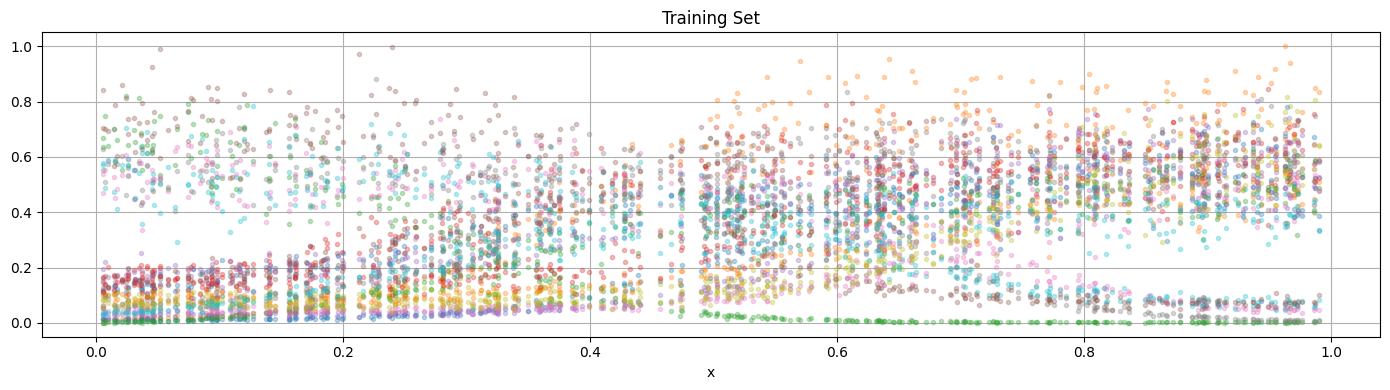

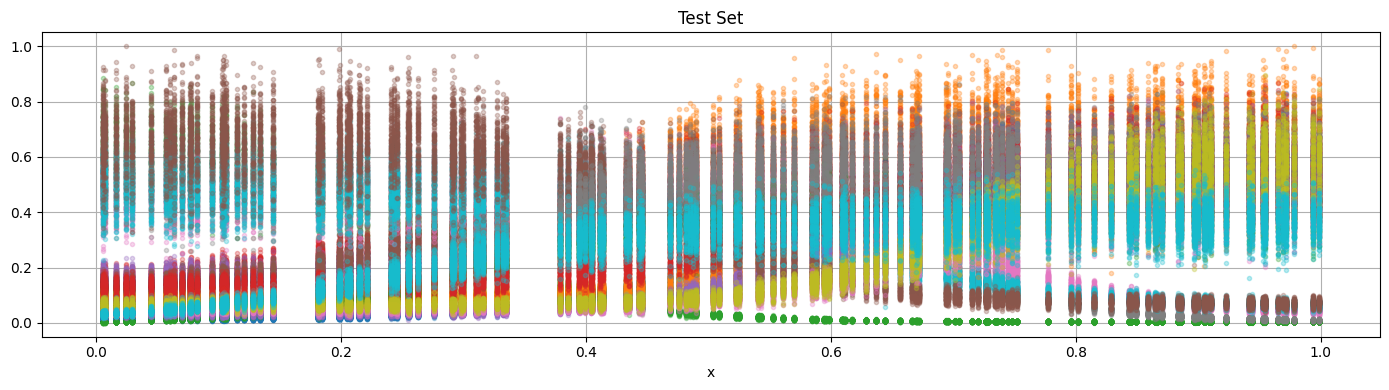

#Examples: 350 (training), 15000 (test)


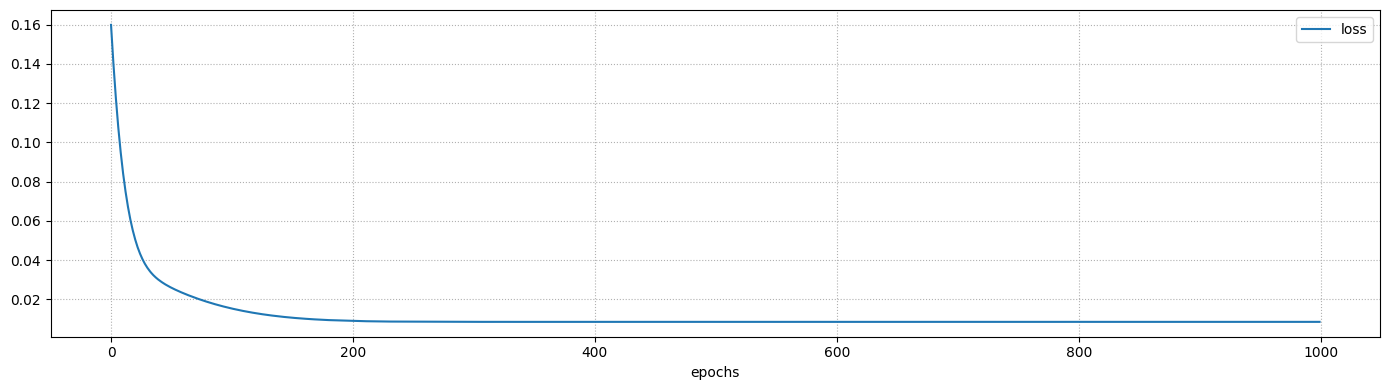

Final loss: 0.0086 (training)
R2: 0.79, MAE: 0.074, RMSE: 0.09 (training)
R2: 0.76, MAE: 0.074, RMSE: 0.09 (test)


In [117]:
import imp
imp.reload(util)

nitems = 20
nsamples_tr = 350
nsamples_ts = 150
nsamples_per_point_tr = 1
nsamples_per_point_ts = 30
noise_scale = 0.15
noise_type = 'normal'
noise_scale_type = 'relative'
rel_req = 0.6
rel_buffer_cost = 10

seed = 42

data_tr = util.generate_costs(nsamples_tr, nitems, seed=seed, sampling_seed=seed,
                              noise_scale=noise_scale, noise_type=noise_type, noise_scale_type=noise_scale_type,
                             nsamples_per_point=nsamples_per_point_tr)
data_ts = util.generate_costs(nsamples_ts, nitems, seed=seed, sampling_seed=seed+1,
                              noise_scale=noise_scale, noise_type=noise_type, noise_scale_type=noise_scale_type,
                             nsamples_per_point=nsamples_per_point_ts)

util.plot_df_cols(data_tr, figsize=figsize, title='Training Set', scatter=True)
util.plot_df_cols(data_ts, figsize=figsize, title='Test Set', scatter=True)

print(f'#Examples: {len(data_tr)} (training), {len(data_ts)} (test)')

tr_in, tr_out = data_tr.index.values, data_tr.values
ts_in, ts_out = data_ts.index.values, data_ts.values

pfl = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[], name='PFL', output_activation='linear')
history = util.train_nn_model(pfl, tr_in, tr_out, epochs=1000, loss='mse', validation_split=0)
util.plot_training_history(history, figsize=figsize)

r2, mae, rmse = util.get_ml_metrics(pfl, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(pfl, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

In [118]:
import imp
imp.reload(util)

prb = util.generate_problem_2s_problem(nitems, requirement=rel_req * data_tr.mean().sum(),
                                       rel_buffer_cost=rel_buffer_cost, seed=seed)

pred_in_ts = np.unique(data_ts.index)
pred_in_selected = pred_in_ts[50]

evpf = util.compute_evpf_2s(prb, pfl, data_ts.loc[pred_in_selected], tlim=10)
print(f'EVPF: {evpf[0]:.2f}')
regret = util.compute_regret_2s(prb, pfl, data_ts.loc[pred_in_selected], tlim=10)
print(f'Regret: {regret[0]:.2f}')

#%time evpf_ts = util.compute_evpf_2s(prb, pfl, data_ts, tlim=10)
#util.plot_histogram(r_ts, figsize=figsize, label='two stage approach', data2=r_ts, label2='test', print_mean=True)

EVPF: 0.58
Regret: 0.34


## SFGE

Epoch 1/50
6/6 [==============================] - 3s 560ms/step - loss: 321.0233 - sigma: 0.1000
Epoch 2/50
6/6 [==============================] - 3s 533ms/step - loss: 317.1753 - sigma: 0.1000
Epoch 3/50
6/6 [==============================] - 3s 523ms/step - loss: 311.2060 - sigma: 0.1000
Epoch 4/50
6/6 [==============================] - 4s 569ms/step - loss: 316.3596 - sigma: 0.1000
Epoch 5/50
6/6 [==============================] - 3s 493ms/step - loss: 311.4753 - sigma: 0.1000
Epoch 6/50
6/6 [==============================] - 4s 631ms/step - loss: 311.9952 - sigma: 0.1000
Epoch 7/50
6/6 [==============================] - 4s 575ms/step - loss: 311.2202 - sigma: 0.1000
Epoch 8/50
6/6 [==============================] - 3s 556ms/step - loss: 315.5455 - sigma: 0.1000
Epoch 9/50
6/6 [==============================] - 4s 617ms/step - loss: 312.9794 - sigma: 0.1000
Epoch 10/50
6/6 [==============================] - 3s 534ms/step - loss: 306.8159 - sigma: 0.1000
Epoch 11/50
6/6 [============

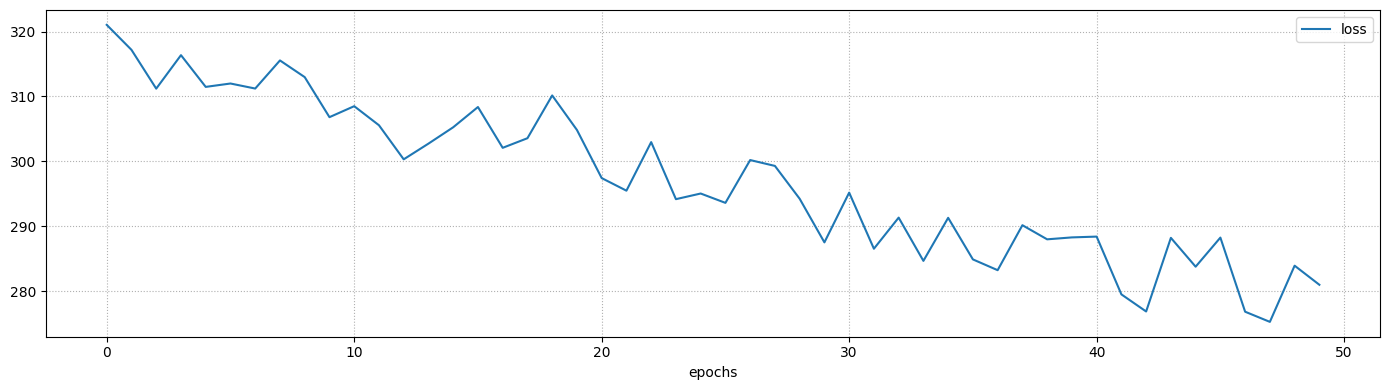

Final loss: 281.0204 (training)
R2: 0.73, MAE: 0.079, RMSE: 0.10 (training)
R2: 0.75, MAE: 0.073, RMSE: 0.09 (test)


In [121]:
import imp
imp.reload(util)

#from tensorflow import keras
#opt = keras.optimizers.Adam(learning_rate=1e-5)
opt = 'Adam'


sfge = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb,
                               hidden=[], name='sfge', output_activation='linear',
                               loss_type='cost',
                               sfge=True, sfge_sigma_init=0.20, sfge_sigma_trainable=False)

pfl_weights = pfl.get_weights()
sfge_weights = sfge.get_weights()
init_weights = pfl_weights[:len(pfl_weights)] + sfge_weights[len(pfl_weights):]
sfge.set_weights(init_weights)

%time history = util.train_dfl_model(sfge, tr_in, tr_out, epochs=50, verbose=1, validation_split=0, optimizer=opt, batch_size=64)
util.plot_training_history(history, figsize=figsize, excluded_metrics=['sigma'])

r2, mae, rmse = util.get_ml_metrics(sfge, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(sfge, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

#r_ts_sfge = util.compute_regret(prb, sfge, ts_in, ts_out)
#util.plot_histogram(r_ts_spo, figsize=figsize, label='spo', data2=r_ts, label2='two stage', print_mean=True)

In [122]:
evpf = util.compute_evpf_2s(prb, sfge, data_ts.loc[pred_in_selected], tlim=10)
print(f'EVPF: {evpf[0]:.2f}')
regret = util.compute_regret_2s(prb, sfge, data_ts.loc[pred_in_selected], tlim=10)
print(f'Regret: {regret[0]:.2f}')

EVPF: 0.22
Regret: 0.04


For debuging:

In [56]:
import imp
imp.reload(util)

prb = util.generate_problem_2s_problem(nitems, requirement=rel_req * data_tr.mean().sum(),
                                       rel_buffer_cost=rel_buffer_cost, seed=seed)

prb.solve([-2.38010049e-01,  6.46904409e-02, -3.85869630e-02, -6.81776479e-02,
       -1.19877510e-01,  1.22626096e-01, -5.84867150e-02, -4.99370769e-02,
       -1.79114044e-01, -1.55258551e-01,  6.21309243e-02,  2.39440240e-04,
       -2.15685144e-02, -1.37320504e-01,  4.88716811e-02, -1.35459425e-03,
       -9.07201841e-02,  2.70379096e-01,  4.05808091e-02,  1.98174641e-02],
         [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 0.])

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 True,
 47.323236614364546,
 0.003]